<a href="https://colab.research.google.com/github/emredeveloper/VeriBilimi-Projeler/blob/main/semantic_segmentation_%26_Pics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Semantic Segmentation

## Applications of Segmentation


The most common use case for the Semantic Segmentation is in:

1. **Autonomous Driving**

  <img src="https://cdn-images-1.medium.com/max/1600/1*JKmS08bllQ8SCajIPyiBBQ.png" width="400"/> <br/>
  <small> Source: CityScapes Dataset </small>
  
  In autonomous driving, the image which comes in from the camera is semantically segmented, thus each pixel in the image is classified
  into a class. This helps the computer understand what is present in the its surroundings and thus helps the car act accordingly.


2. **Facial Segmentation**

  <img src="https://i.ytimg.com/vi/vrvwfFej_r4/maxresdefault.jpg" width="400"/> <br/>
  <small> Source: https://github.com/massimomauro/FASSEG-repository/blob/master/papers/multiclass_face_segmentation_ICIP2015.pdf </small>

  Facial Segmentation is used for segmenting each part of the face into a category, like lips, eyes etc. This technique is used for
  many purposes such as gender estimation, age estimation, facial expression analysis, emotional analysis and more.
  

3. **Indoor Object Segmentation**

  <img src="https://cs.nyu.edu/~silberman/rmrc2014/header_semantic_segmentation.jpg" width="400"/><br/>
  <small> Source: http://buildingparser.stanford.edu/dataset.html </small>

  Guess where is this used? In AR (Augmented Reality) and VR (Virtual Reality). AR applications when required segments the entire indoor area to understand where there
  are chairs, tables, people, wall, and other obstacles and so on.


4. **Geo-Land Sensing**

  <img src="https://ars.els-cdn.com/content/image/1-s2.0-S0924271616305305-fx1_lrg.jpg" width="400"/> <br/>
  <small> Source: https://www.sciencedirect.com/science/article/pii/S0924271616305305 </small>

  Geo Land Sensing is a way of categorizing each pixel in satellite images into a category such that we can track the land cover of each
  area. So, say in some area there is a heavy deforestation taking place then appropriate measures can be taken.


### FCN with Resnet-101 backbone

FCN - Fully Convolutional Netowrks, are among the most early invented Neural Networks for the task of Semantic Segmentation.

Let's load one up!

In [1]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [00:05<00:00, 36.7MB/s]


2024-01-13 13:22:33 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182965/182965] -> "bird.png" [1]


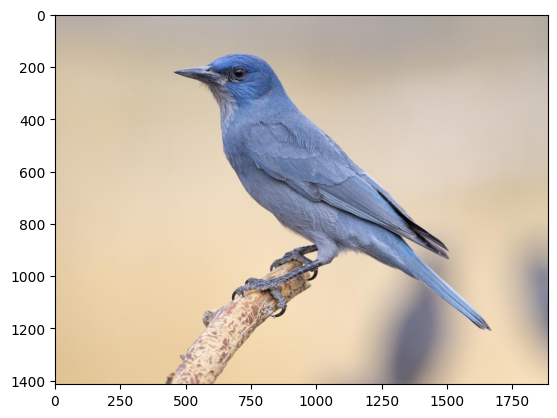

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png
img = Image.open('./bird.png')
plt.imshow(img); plt.show()

In [3]:
# Apply the transformations needed
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(),
                 T.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

In [4]:
# Pass the input through the net
out = fcn(inp)['out']
print (out.shape)

torch.Size([1, 21, 224, 224])


In [5]:
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

(224, 224)
[0 3]


In [6]:
# Define the helper function
def decode_segmap(image, nc=21):

  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)

  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]

  rgb = np.stack([r, g, b], axis=2)
  return rgb

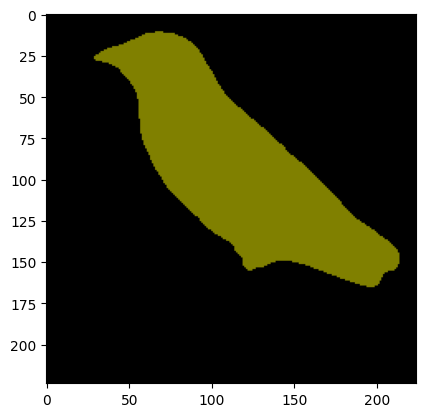

In [7]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

In [8]:
def segment(net, path, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(640),
                   #T.CenterCrop(224),
                   T.ToTensor(),
                   T.Normalize(mean = [0.485, 0.456, 0.406],
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.axis('off'); plt.show()

And let's get a new image!

2024-01-13 13:23:12 URL:http://learnopencv.com/wp-content/uploads/2021/01/horse-segmentation.jpeg [128686/128686] -> "horse.png" [1]


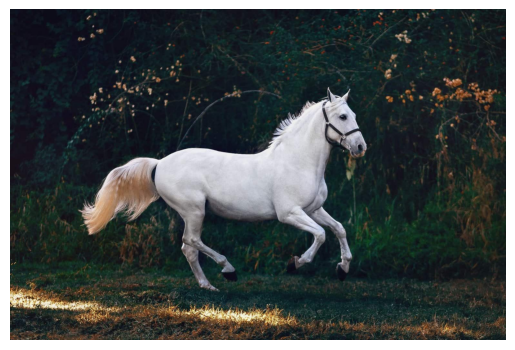

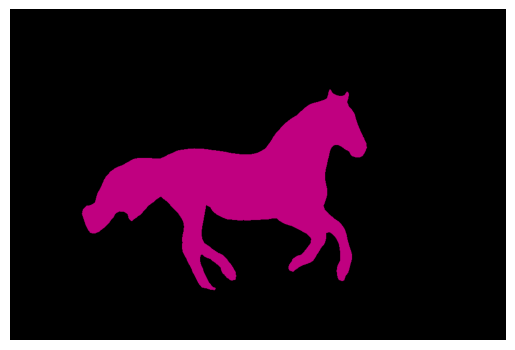

In [9]:
!wget -nv https://www.learnopencv.com/wp-content/uploads/2021/01/horse-segmentation.jpeg -O horse.png
segment(fcn, './horse.png')

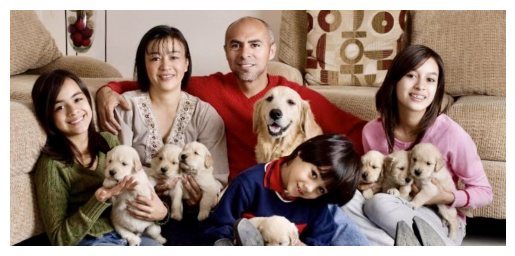

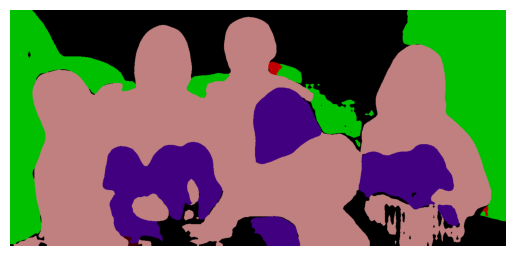

In [18]:
segment(fcn,'./aile_kopek.jpg')

### DeepLabv3

In [10]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:03<00:00, 72.5MB/s]


Alright! Now we have god-level segmentation model!<br/>
Let's see how we perform with the same image on this model!

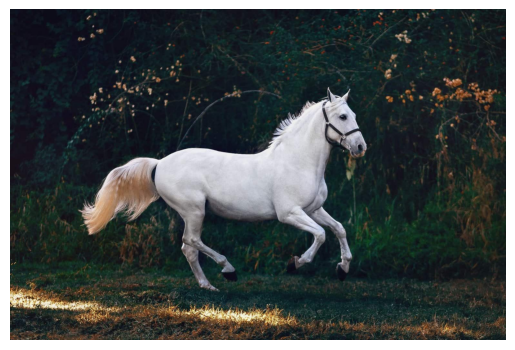

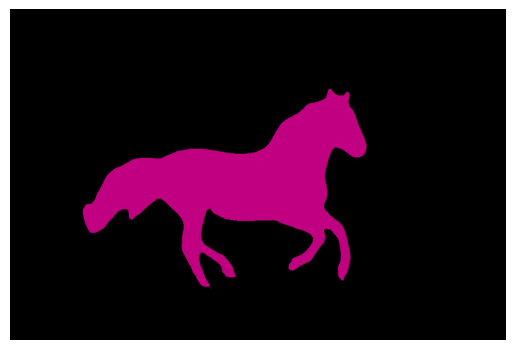

In [11]:
segment(dlab, './horse.png')

2024-01-13 13:23:54 URL:http://learnopencv.com/wp-content/uploads/2021/01/person-segmentation.jpeg [95431/95431] -> "person.png" [1]


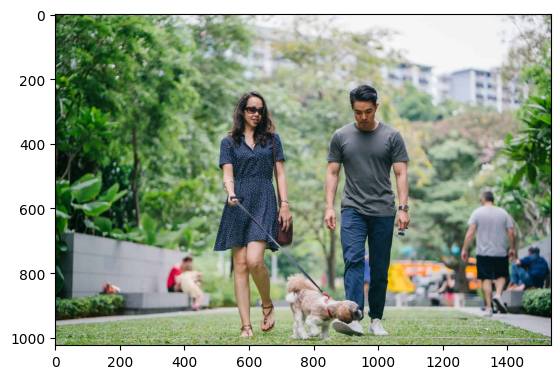

Segmenatation Image on FCN


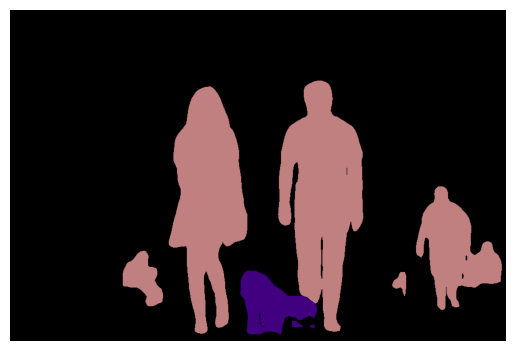

Segmenatation Image on DeepLabv3


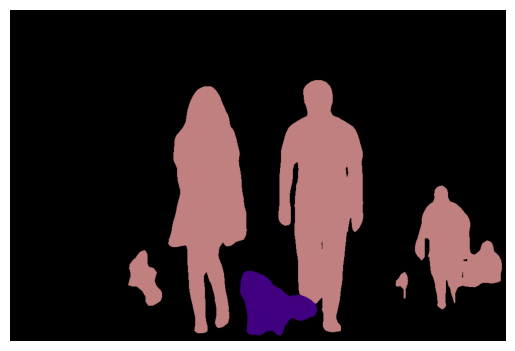

In [12]:
!wget -nv "https://www.learnopencv.com/wp-content/uploads/2021/01/person-segmentation.jpeg" -O person.png
img = Image.open('./person.png')
plt.imshow(img); plt.show()

print ('Segmenatation Image on FCN')
segment(fcn, path='./person.png', show_orig=False)

print ('Segmenatation Image on DeepLabv3')
segment(dlab, path='./person.png', show_orig=False)

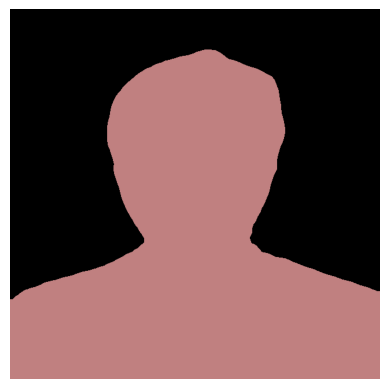

In [16]:
segment(dlab, path='./emre.jpg', show_orig=False)

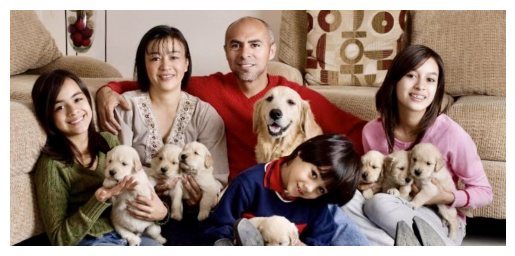

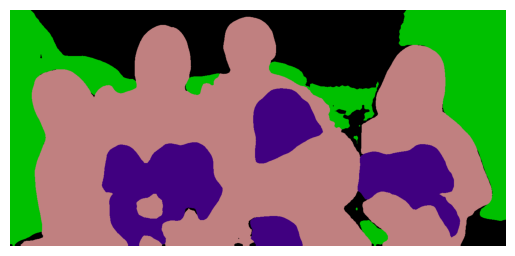

In [17]:
segment(dlab, path='./aile_kopek.jpg', show_orig=True)